In [1]:
import sys
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('/share/PI/rondror/docking_code/notebooks/')
from load_data import *
from plotting_tools import *

sys.path.append('/share/PI/rondror/docking_code/3_score/')
from optimize import Scores

In [8]:
data_set_dir = '/scratch/PI/rondror/docking_data/TRMD/'   
   
rmsd_file = 'rmsd.csv'
ligands_dir = data_set_dir + 'ligands/'
grids_dir = data_set_dir + 'grids/'
glide_dir = data_set_dir + 'glide/'
crystal_fp_file = data_set_dir + 'structure_fingerprints/ifp.fp'
docking_fp_dir = data_set_dir + 'docking_fingerprints/'

#crystal_fp_file_no_angle = data_set_dir + 'structure_fingerprints_no_angle/ifp.fp'
#docking_fp_dir_no_angle = data_set_dir + 'docking_fingerprints_no_angle/'

In [9]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints
(TRMD_crystals, TRMD_glides) = load_data(
    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)

#(TRMD_crystals_no_angle, TRMD_glides_no_angle) = load_data(
#    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file_no_angle, docking_fp_dir_no_angle)

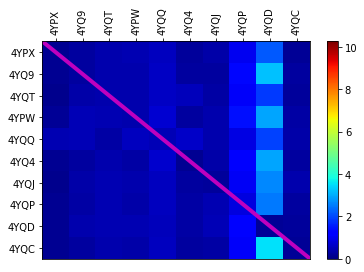

In [10]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

get_ipython().magic(u'matplotlib inline')

max_num_poses = 50

# this shows the rmsds of glide's top ranked poses (pose 0)
top_rmsd_matrix = top_pose(TRMD_glides)
#heatmap(top_rmsd_matrix, TRMD_glides)

# this shows the losest rmsd in the first 'max_num_poses' poses
best_rmsd_matrix = best_pose(TRMD_glides, max_num_poses)
heatmap(best_rmsd_matrix, TRMD_glides)

In [11]:
## STEP 3:
## pick 1 receptor structure to use for all ligands
## filter ligands that are poorly docked

rmsd_filter = lambda x: x < 2
best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, TRMD_glides.keys())

print 'The best structure is ' + best_structure
print str(len(filtered_ligands)) + ' of ' + str(len(TRMD_glides.keys())) + ' ligands were docked well:'
print filtered_ligands
print 'with an average best rmsd of ' + str(ave_rmsd)[:5]

The best structure is 4YQD
10 of 10 ligands were docked well:
['4YPX', '4YQ9', '4YQT', '4YPW', '4YQQ', '4YQ4', '4YQJ', '4YQP', '4YQD', '4YQC']
with an average best rmsd of 0.466


In [12]:
## STEP 4:
## score all pairs of ligands

# optional arguments: overlap (function) and weights (dictionary of interaction_index to weight)
scores = Scores(TRMD_glides, TRMD_crystals, filtered_ligands, best_structure, max_num_poses)

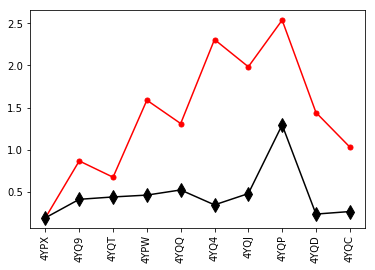

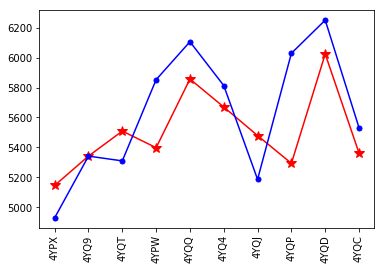

In [13]:
## STEP 5:
## plot results

plot_final_rmsds(scores)
plot_final_scores(scores)

In [ ]:
## STEP 4:
## look at the highest-scoring pose of each pair of ligands

get_ipython().magic(u'matplotlib inline')

a = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)

pairs = show_results_for_all_ligand_pairs(scores, scores2=None)

matplotlib.rcParams['figure.figsize'] = a

In [ ]:
## STEP 5: find the worst pair

(l1, l2, worst_rmsd) = pairs[44]#np.argmax([pairs[i][2] for i in pairs])]

print 'The highest rmsd value is ' + str(worst_rmsd)
print 'for pair ' + l1 + ', ' + l2

In [ ]:
## STEP 6: debug the worst pair

get_ipython().magic(u'matplotlib inline')

plot_all_poses(l1, l2, scores, l1 + ' ' + l2)#, scores2, label2)

In [ ]:
## use this block to extract interesting pairs from the plot above

'''
scored_pairs[0][pair], # rmsd ave
scored_pairs[1][pair], # gscore sum
scored_pairs[2][pair], # pair score
scored_pairs[3][pair], # l1 pose num
scored_pairs[4][pair]))# l2 pose num
'''

bad_rmsd = lambda r1,r2: (r1+r2)/2.0 >= 2
good_rmsd = lambda r1,r2: (r1+r2)/2.0 <= 1
good_score = lambda score: score >= 50
combo = lambda rmsd, score: score and rmsd

# output: p1, p2, r1, r2, score(p1,p2)
bad_pairs = scores.get_filtered_pose_pairs(l1, l2, bad_rmsd, good_score, combo)
bad_pairs.sort(key=lambda x: x[5])
bad_pairs.reverse()

good_pairs = scores.get_filtered_pose_pairs(l1, l2, good_rmsd, good_score, combo)
good_pairs.sort(key=lambda x: x[5])
good_pairs.reverse()

print l1, l2
print 'Bad pairs:'
for i in range(min(5, len(bad_pairs))):
    print bad_pairs[i]
print 'Good pairs:'
for i in range(min(5, len(good_pairs))):
    print good_pairs[i]

In [ ]:
(bad_score,  bad_interactions)  = scores.get_interactions(l1, l2, bad_pairs[0][0],  bad_pairs[0][1])
(good_score, good_interactions) = scores.get_interactions(l1, l2, good_pairs[0][0], good_pairs[0][1])
(true_score, true_interactions) = scores.get_interactions(l1, l2, -1, -1)

# returns list of tuples: (arg1_strength - arg2_strenth, res, interaction_type)
explore_1 = find_mismatched_interactions(true_interactions, good_interactions)
explore_2 = find_mismatched_interactions(true_interactions, bad_interactions)

explore_1.sort(key=lambda x: abs(x[0]), reverse=True) # sort on absolute value of the mismatch
explore_2.sort(key=lambda x: x[0])

print 'Biggest mismatches between the good pose and the crystal pose'
for i in range(10):
    print explore_1[i]
print '--------'
print 'Biggest negative mismatches between the bad pose and the crystal pose'
for i in range(10):
    print explore_2[i]

In [ ]:
#print p1_good.fp.feats['133']
#print p2_good.fp.feats['133']
print p1_good.fp.feats['136']
print p2_good.fp.feats['136']

print '------'
print crystal_fp1.feats['136']
print crystal_fp2.feats['136']
print '------'
'''for r in p1_bad.fp.feats:
    max_str = max([abs(i) for i in p1_bad.fp.feats[r]])
    if max_str > 5:
        print r, p1_bad.fp.feats[r]
    #h1_str = p1_bad.fp.feats[r][0]
    #h2_str = p1_bad.fp.feats[r][1]
    #if h1_str > 1 or h2_str > 1:
    #    print r, h1_str, h2_str
print '------'
for r in crystal_fp1.feats:
    h1_str = crystal_fp1.feats[r][0]
    h2_str = crystal_fp1.feats[r][1]
    if h1_str > 2 or h2_str > 2:
        print r, h1_str, h2_str'''

In [ ]:
for l in filtered_ligands:
    print l, final_poses[l], TRMD_glides[l][best_structure].poses[final_poses[l]].rmsd